Train Epoch: 1 [0/60000 (0%)]	Loss: 69671.562500
Train Epoch: 1 [12800/60000 (21%)]	Loss: 24789.945312
Train Epoch: 1 [25600/60000 (43%)]	Loss: 23465.349609
Train Epoch: 1 [38400/60000 (64%)]	Loss: 21887.550781
Train Epoch: 1 [51200/60000 (85%)]	Loss: 17900.738281
Train Epoch: 2 [0/60000 (0%)]	Loss: 18220.812500
Train Epoch: 2 [12800/60000 (21%)]	Loss: 17310.503906
Train Epoch: 2 [25600/60000 (43%)]	Loss: 16975.726562
Train Epoch: 2 [38400/60000 (64%)]	Loss: 15876.276367
Train Epoch: 2 [51200/60000 (85%)]	Loss: 15654.467773
Train Epoch: 3 [0/60000 (0%)]	Loss: 14380.136719
Train Epoch: 3 [12800/60000 (21%)]	Loss: 15482.219727
Train Epoch: 3 [25600/60000 (43%)]	Loss: 14942.690430
Train Epoch: 3 [38400/60000 (64%)]	Loss: 15521.339844
Train Epoch: 3 [51200/60000 (85%)]	Loss: 14968.154297
Train Epoch: 4 [0/60000 (0%)]	Loss: 14742.555664
Train Epoch: 4 [12800/60000 (21%)]	Loss: 14504.091797
Train Epoch: 4 [25600/60000 (43%)]	Loss: 14560.855469
Train Epoch: 4 [38400/60000 (64%)]	Loss: 14902.9

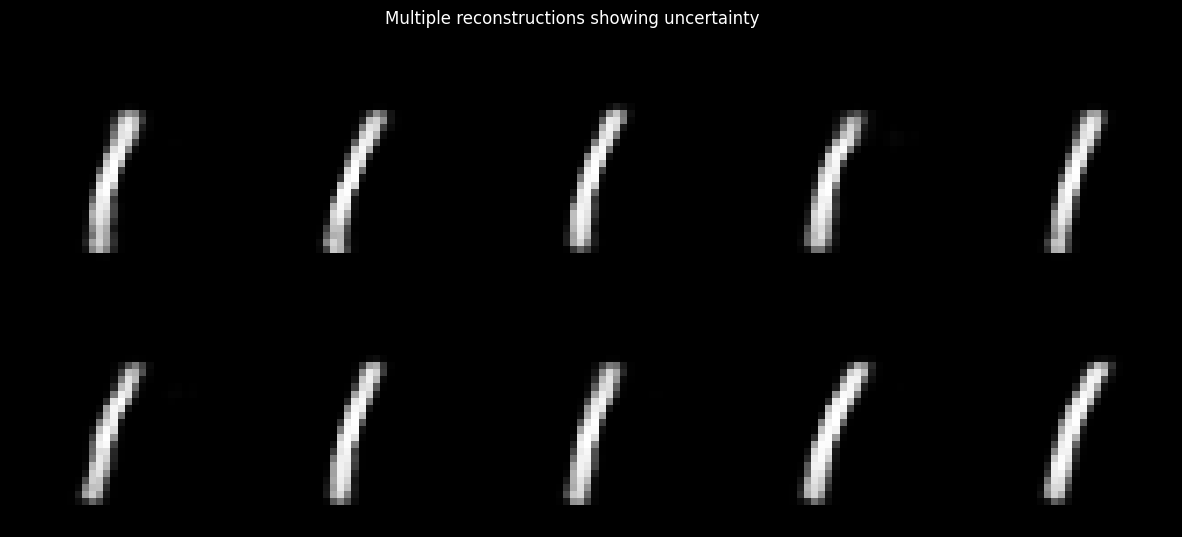

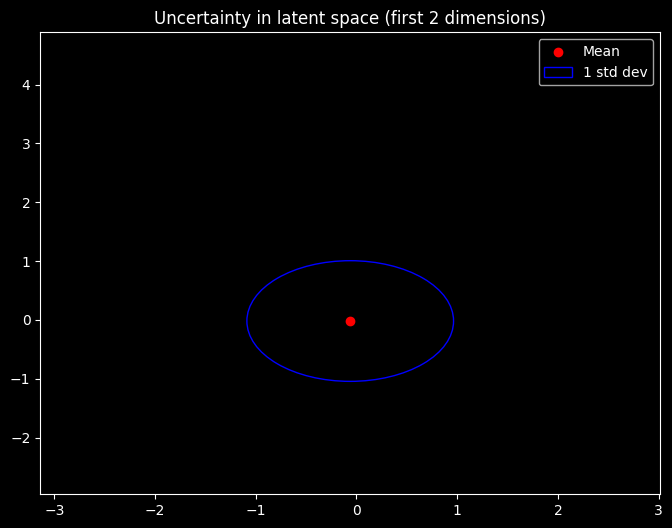

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        # Encoder
        self.enc1 = nn.Linear(input_dim, hidden_dim)
        self.enc2 = nn.Linear(hidden_dim, hidden_dim)
        self.enc_mean = nn.Linear(hidden_dim, latent_dim)
        self.enc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.dec1 = nn.Linear(latent_dim, hidden_dim)
        self.dec2 = nn.Linear(hidden_dim, hidden_dim)
        self.dec3 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        h = F.relu(self.enc1(x))
        h = F.relu(self.enc2(h))
        mean = self.enc_mean(h)
        logvar = self.enc_logvar(h)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def decode(self, z):
        h = F.relu(self.dec1(z))
        h = F.relu(self.dec2(h))
        return torch.sigmoid(self.dec3(h))
    
    def forward(self, x):
        mean, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

# Loss function
def loss_function(recon_x, x, mean, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return BCE + KLD

# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mean, logvar = model(data)
        loss = loss_function(recon_batch, data, mean, logvar)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Function to visualize uncertainty
def visualize_uncertainty(model, data, device):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        mean, logvar = model.encode(data.view(-1, 784))
        std = torch.exp(0.5 * logvar)
        
        # Generate multiple reconstructions
        num_samples = 10
        reconstructions = []
        for _ in range(num_samples):
            z = model.reparameterize(mean, logvar)
            recon = model.decode(z)
            reconstructions.append(recon.view(28, 28).cpu().numpy())
        
        # Visualize
        fig, axs = plt.subplots(2, 5, figsize=(15, 6))
        for i, recon in enumerate(reconstructions):
            ax = axs[i // 5, i % 5]
            ax.imshow(recon, cmap='gray')
            ax.axis('off')
        plt.suptitle('Multiple reconstructions showing uncertainty')
        plt.show()
        
        # Visualize uncertainty in latent space (first two dimensions)
        plt.figure(figsize=(8, 6))
        plt.scatter(mean[0, 0].item(), mean[0, 1].item(), c='r', label='Mean')
        circle = plt.Circle((mean[0, 0].item(), mean[0, 1].item()), std[0, 0].item(), fill=False, color='b', label='1 std dev')
        plt.gca().add_artist(circle)
        plt.xlim(mean[0, 0].item() - 3*std[0, 0].item(), mean[0, 0].item() + 3*std[0, 0].item())
        plt.ylim(mean[0, 1].item() - 3*std[0, 1].item(), mean[0, 1].item() + 5*std[0, 1].item())
        plt.legend()
        plt.title('Uncertainty in latent space (first 2 dimensions)')
        plt.show()

# Main training loop
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load MNIST dataset
    train_loader = DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.ToTensor()),
        batch_size=128, shuffle=True)
    
    model = VAE(784, 400, 20).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    for epoch in range(1, 11):
        train(model, device, train_loader, optimizer, epoch)
    
    # Visualize uncertainty for a sample image
    sample_data = next(iter(train_loader))[0][0].unsqueeze(0)
    visualize_uncertainty(model, sample_data, device)

if __name__ == '__main__':
    main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 69792.171875
Train Epoch: 1 [12800/60000 (21%)]	Loss: 25595.636719
Train Epoch: 1 [25600/60000 (43%)]	Loss: 23352.488281
Train Epoch: 1 [38400/60000 (64%)]	Loss: 19924.900391
Train Epoch: 1 [51200/60000 (85%)]	Loss: 18667.669922
====> Epoch: 1 Average loss: 177.0206
Train Epoch: 2 [0/60000 (0%)]	Loss: 17245.873047
Train Epoch: 2 [12800/60000 (21%)]	Loss: 17192.263672
Train Epoch: 2 [25600/60000 (43%)]	Loss: 15937.852539
Train Epoch: 2 [38400/60000 (64%)]	Loss: 16440.134766
Train Epoch: 2 [51200/60000 (85%)]	Loss: 15914.983398
====> Epoch: 2 Average loss: 129.8110
Train Epoch: 3 [0/60000 (0%)]	Loss: 14961.172852
Train Epoch: 3 [12800/60000 (21%)]	Loss: 15640.166016
Train Epoch: 3 [25600/60000 (43%)]	Loss: 15288.454102
Train Epoch: 3 [38400/60000 (64%)]	Loss: 15379.359375
Train Epoch: 3 [51200/60000 (85%)]	Loss: 14691.752930
====> Epoch: 3 Average loss: 119.1179
Train Epoch: 4 [0/60000 (0%)]	Loss: 15236.985352
Train Epoch: 4 [12800/60000 (21%)]	Loss: 1

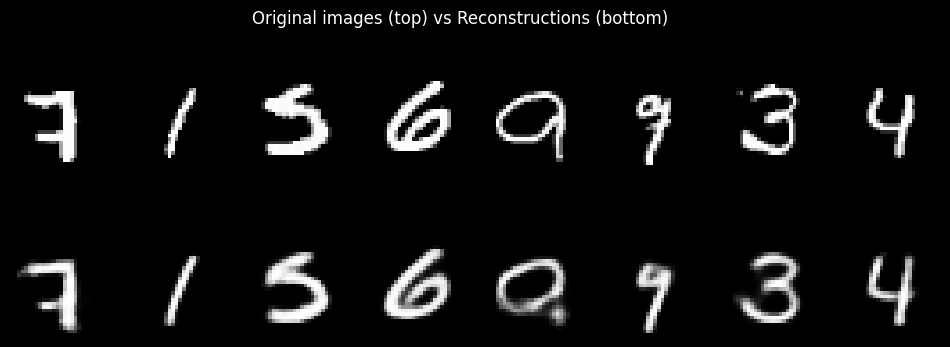

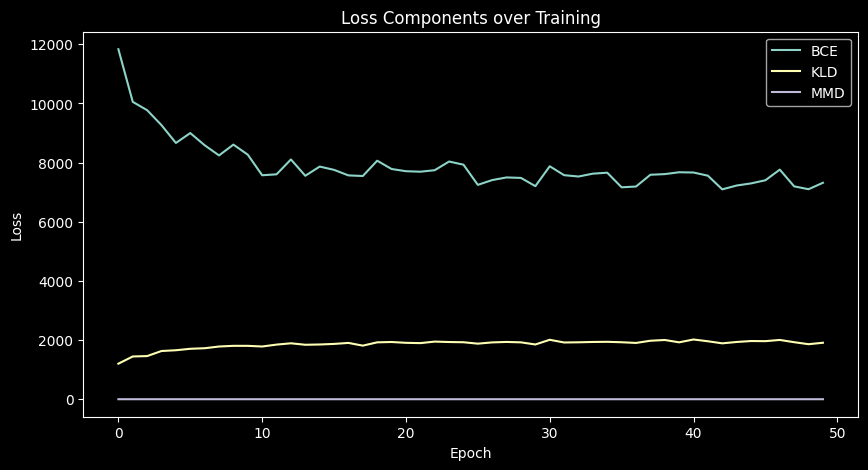

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class InfoVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(InfoVAE, self).__init__()
        
        # Encoder
        self.enc1 = nn.Linear(input_dim, hidden_dim)
        self.enc2 = nn.Linear(hidden_dim, hidden_dim)
        self.enc_mean = nn.Linear(hidden_dim, latent_dim)
        self.enc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.dec1 = nn.Linear(latent_dim, hidden_dim)
        self.dec2 = nn.Linear(hidden_dim, hidden_dim)
        self.dec3 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        h = F.relu(self.enc1(x))
        h = F.relu(self.enc2(h))
        mean = self.enc_mean(h)
        logvar = self.enc_logvar(h)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def decode(self, z):
        h = F.relu(self.dec1(z))
        h = F.relu(self.dec2(h))
        return torch.sigmoid(self.dec3(h))
    
    def forward(self, x):
        mean, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

# Gaussian kernel for MMD
def gaussian_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1).expand(x_size, y_size, dim)
    y = y.unsqueeze(0).expand(x_size, y_size, dim)
    return torch.exp(-torch.pow(x - y, 2).sum(2) / float(dim))

# Compute Maximum Mean Discrepancy (MMD)
def compute_mmd(x, y):
    x_kernel = gaussian_kernel(x, x)
    y_kernel = gaussian_kernel(y, y)
    xy_kernel = gaussian_kernel(x, y)
    return x_kernel.mean() + y_kernel.mean() - 2 * xy_kernel.mean()

# Modified loss function for InfoVAE
def loss_function(recon_x, x, mean, logvar, z, alpha=1.0, lambda_mmd=1000):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    
    # Compute MMD between z and a sample from the prior
    true_samples = torch.randn_like(z)
    mmd_loss = compute_mmd(true_samples, z)
    
    return BCE + alpha * KLD + lambda_mmd * mmd_loss, BCE, KLD, mmd_loss

# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mean, logvar = model(data)
        z = model.reparameterize(mean, logvar)
        loss, bce, kld, mmd = loss_function(recon_batch, data, mean, logvar, z)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    return bce.item(), kld.item(), mmd.item()

# Function to visualize reconstructions
def visualize_reconstructions(model, data, device):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        recon_batch, _, _ = model(data)
        
        n = min(data.size(0), 8)
        comparison = torch.cat([data[:n],
                                recon_batch.view(128, 1, 28, 28)[:n]])
        plt.figure(figsize=(12, 4))
        for i in range(n * 2):
            plt.subplot(2, n, i + 1)
            plt.imshow(comparison[i].cpu().view(28, 28), cmap='gray')
            plt.axis('off')
        plt.suptitle('Original images (top) vs Reconstructions (bottom)')
        plt.show()

# Main training loop
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load MNIST dataset
    train_loader = DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.ToTensor()),
        batch_size=128, shuffle=True)
    
    model = InfoVAE(784, 400, 20).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    bce_losses, kld_losses, mmd_losses = [], [], []
    
    for epoch in range(1, 51):
        bce, kld, mmd = train(model, device, train_loader, optimizer, epoch)
        bce_losses.append(bce)
        kld_losses.append(kld)
        mmd_losses.append(mmd)
    
    # Visualize reconstructions for a batch of images
    sample_data = next(iter(train_loader))[0]
    visualize_reconstructions(model, sample_data, device)
    
    # Plot loss components
    plt.figure(figsize=(10, 5))
    plt.plot(bce_losses, label='BCE')
    plt.plot(kld_losses, label='KLD')
    plt.plot(mmd_losses, label='MMD')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Components over Training')
    plt.show()

if __name__ == '__main__':
    main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 69699.632812
Train Epoch: 1 [12800/60000 (21%)]	Loss: 23400.964844
Train Epoch: 1 [25600/60000 (43%)]	Loss: 23080.480469
Train Epoch: 1 [38400/60000 (64%)]	Loss: 22491.142578
Train Epoch: 1 [51200/60000 (85%)]	Loss: 21248.128906
====> Epoch: 1 Average loss: 183.3252
Train Epoch: 2 [0/60000 (0%)]	Loss: 21750.455078
Train Epoch: 2 [12800/60000 (21%)]	Loss: 21281.960938
Train Epoch: 2 [25600/60000 (43%)]	Loss: 20361.207031
Train Epoch: 2 [38400/60000 (64%)]	Loss: 20910.955078
Train Epoch: 2 [51200/60000 (85%)]	Loss: 19294.982422
====> Epoch: 2 Average loss: 160.6222
Train Epoch: 3 [0/60000 (0%)]	Loss: 19455.197266
Train Epoch: 3 [12800/60000 (21%)]	Loss: 19314.679688
Train Epoch: 3 [25600/60000 (43%)]	Loss: 19584.279297
Train Epoch: 3 [38400/60000 (64%)]	Loss: 19787.859375
Train Epoch: 3 [51200/60000 (85%)]	Loss: 19752.312500
====> Epoch: 3 Average loss: 154.9965
Train Epoch: 4 [0/60000 (0%)]	Loss: 19038.437500
Train Epoch: 4 [12800/60000 (21%)]	Loss: 1

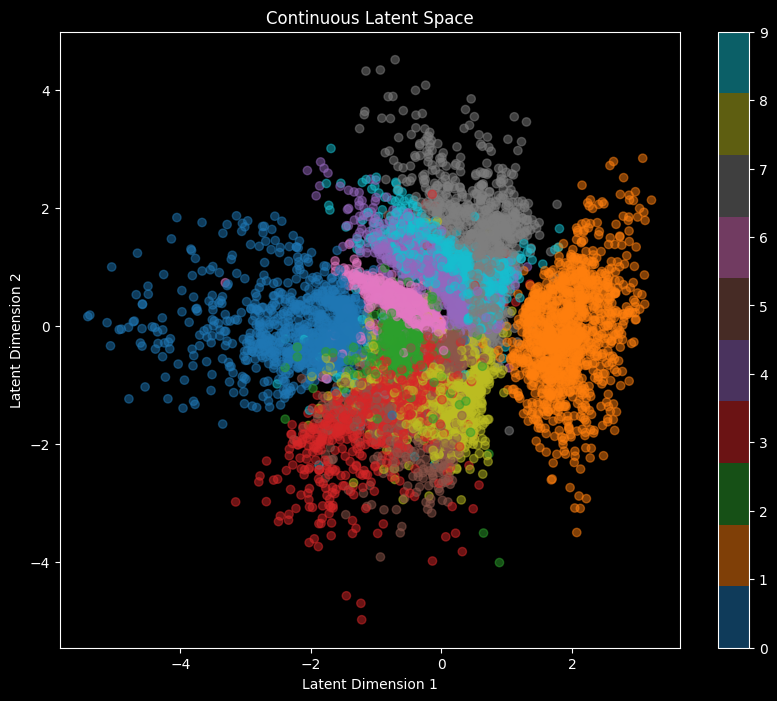

ValueError: 'c' argument has 10000 elements, which is inconsistent with 'x' and 'y' with size 100000.

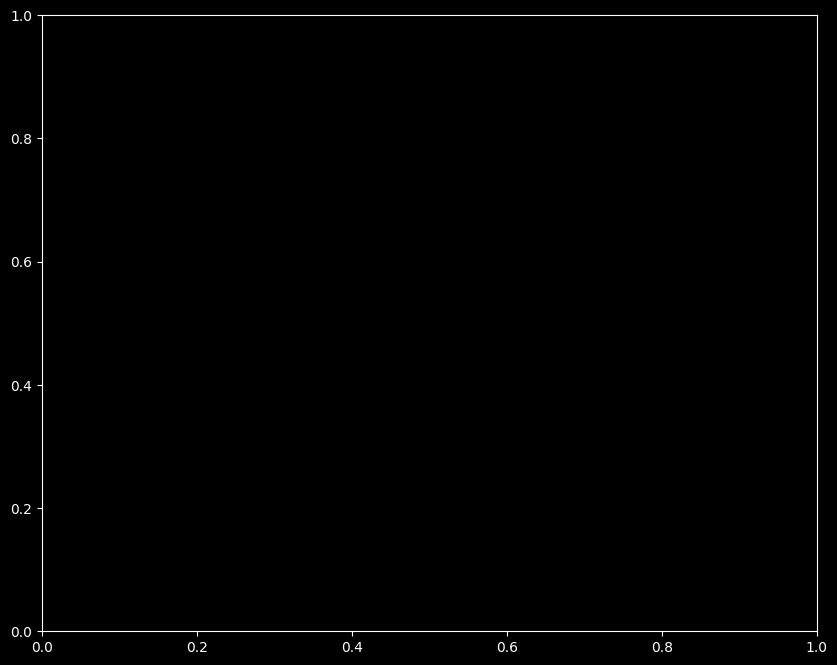

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Continuous VAE
class ContinuousVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(ContinuousVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Discrete VAE (using Gumbel-Softmax for differentiability)
class DiscreteVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_categories):
        super(DiscreteVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_logits = nn.Linear(hidden_dim, latent_dim * num_categories)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim * num_categories, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        self.latent_dim = latent_dim
        self.num_categories = num_categories

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_logits(h).view(-1, self.latent_dim, self.num_categories)

    def reparameterize(self, logits, tau=1.0):
        return F.gumbel_softmax(logits, tau=tau, hard=True)

    def decode(self, z):
        return self.decoder(z.view(-1, self.latent_dim * self.num_categories))

    def forward(self, x):
        logits = self.encode(x.view(-1, 784))
        z = self.reparameterize(logits)
        return self.decode(z), logits

# Loss functions
def continuous_loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def discrete_loss_function(recon_x, x, logits):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    log_qz = F.log_softmax(logits, dim=-1)
    KLD = torch.sum(torch.exp(log_qz) * log_qz)
    return BCE + KLD

# Training function
def train(model, device, train_loader, optimizer, epoch, loss_function, is_discrete=False):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        if is_discrete:
            recon_batch, logits = model(data)
            loss = loss_function(recon_batch, data, logits)
        else:
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')


# Updated visualization function
def visualize_latent_space(model, device, test_loader, is_discrete=False, max_samples=10000):
    model.eval()
    latent_vectors = []
    labels = []
    sample_count = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            if sample_count >= max_samples:
                break
            data = data.to(device)
            batch_size = data.size(0)
            if is_discrete:
                logits = model.encode(data.view(-1, 784))
                z = F.softmax(logits, dim=-1)
            else:
                mu, _ = model.encode(data.view(-1, 784))
                z = mu
            latent_vectors.append(z.cpu())
            labels.append(target)
            sample_count += batch_size

    latent_vectors = torch.cat(latent_vectors, dim=0).numpy()[:max_samples]
    labels = torch.cat(labels, dim=0).numpy()[:max_samples]

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.colorbar(scatter)
    plt.title('Continuous Latent Space' if not is_discrete else 'Discrete Latent Space')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)
test_loader = DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=128, shuffle=False)

# Train Continuous VAE
continuous_vae = ContinuousVAE(784, 400, 2).to(device)
optimizer = optim.Adam(continuous_vae.parameters())
for epoch in range(1, 11):
    train(continuous_vae, device, train_loader, optimizer, epoch, continuous_loss_function)

# Train Discrete VAE
discrete_vae = DiscreteVAE(784, 400, 2, 10).to(device)
optimizer = optim.Adam(discrete_vae.parameters())
for epoch in range(1, 11):
    train(discrete_vae, device, train_loader, optimizer, epoch, discrete_loss_function, is_discrete=True)

# Visualize latent spaces
visualize_latent_space(continuous_vae, device, test_loader)
visualize_latent_space(discrete_vae, device, test_loader, is_discrete=True)


    

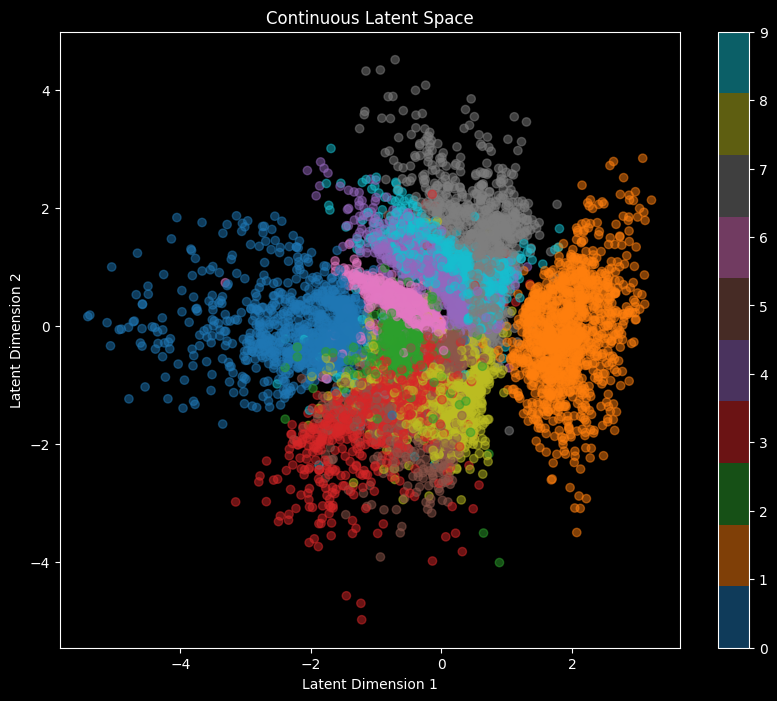

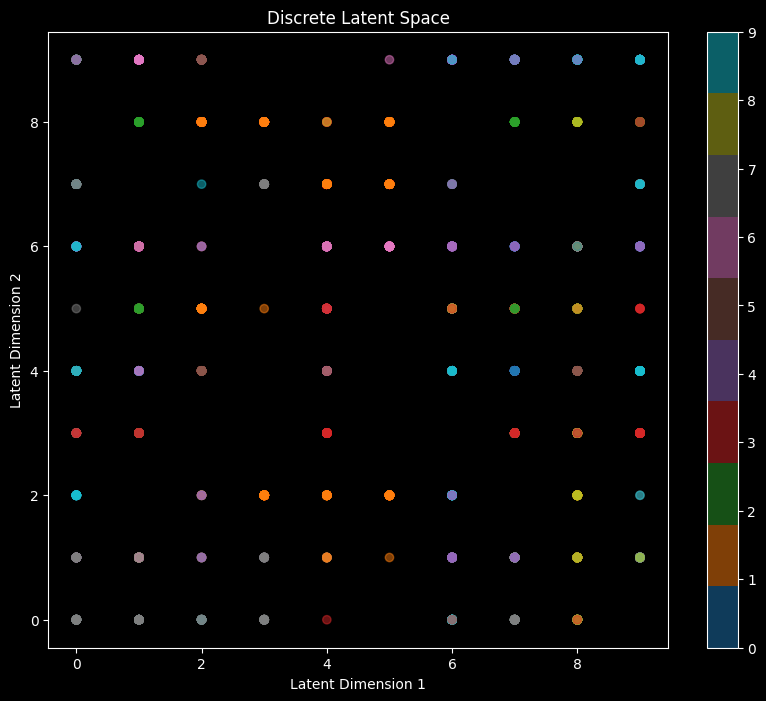

In [17]:
# Updated visualization function
def visualize_latent_space(model, device, test_loader, is_discrete=False, max_samples=10000):
    model.eval()
    latent_vectors = []
    labels = []
    sample_count = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            if sample_count >= max_samples:
                break
            data = data.to(device)
            batch_size = data.size(0)
            if is_discrete:
                logits = model.encode(data.view(-1, 784))
                z = F.softmax(logits, dim=-1)
            else:
                mu, _ = model.encode(data.view(-1, 784))
                z = mu
            latent_vectors.append(z.cpu())
            labels.append(target)
            sample_count += batch_size

    latent_vectors = torch.cat(latent_vectors, dim=0).numpy()[:max_samples]
    labels = torch.cat(labels, dim=0).numpy()[:max_samples]

    plt.figure(figsize=(10, 8))
    if is_discrete:
        latent_vectors = latent_vectors.argmax(axis=-1)
        
    scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.colorbar(scatter)
    plt.title('Continuous Latent Space' if not is_discrete else 'Discrete Latent Space')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

visualize_latent_space(continuous_vae, device, test_loader)
visualize_latent_space(discrete_vae, device, test_loader, is_discrete=True)

Train Epoch: 1 [0/60000 (0%)]	Loss: 69772.898438
Train Epoch: 1 [12800/60000 (21%)]	Loss: 25752.003906
Train Epoch: 1 [25600/60000 (43%)]	Loss: 23585.949219
Train Epoch: 1 [38400/60000 (64%)]	Loss: 20068.847656
Train Epoch: 1 [51200/60000 (85%)]	Loss: 19026.216797
====> Epoch: 1 Average loss: 180.3904
Train Epoch: 2 [0/60000 (0%)]	Loss: 18212.873047
Train Epoch: 2 [12800/60000 (21%)]	Loss: 17014.109375
Train Epoch: 2 [25600/60000 (43%)]	Loss: 16090.656250
Train Epoch: 2 [38400/60000 (64%)]	Loss: 16050.482422
Train Epoch: 2 [51200/60000 (85%)]	Loss: 16176.794922
====> Epoch: 2 Average loss: 129.8476
Train Epoch: 3 [0/60000 (0%)]	Loss: 15110.735352
Train Epoch: 3 [12800/60000 (21%)]	Loss: 15091.804688
Train Epoch: 3 [25600/60000 (43%)]	Loss: 14983.006836
Train Epoch: 3 [38400/60000 (64%)]	Loss: 14921.861328
Train Epoch: 3 [51200/60000 (85%)]	Loss: 14068.018555
====> Epoch: 3 Average loss: 118.9140
Train Epoch: 4 [0/60000 (0%)]	Loss: 15085.587891
Train Epoch: 4 [12800/60000 (21%)]	Loss: 1

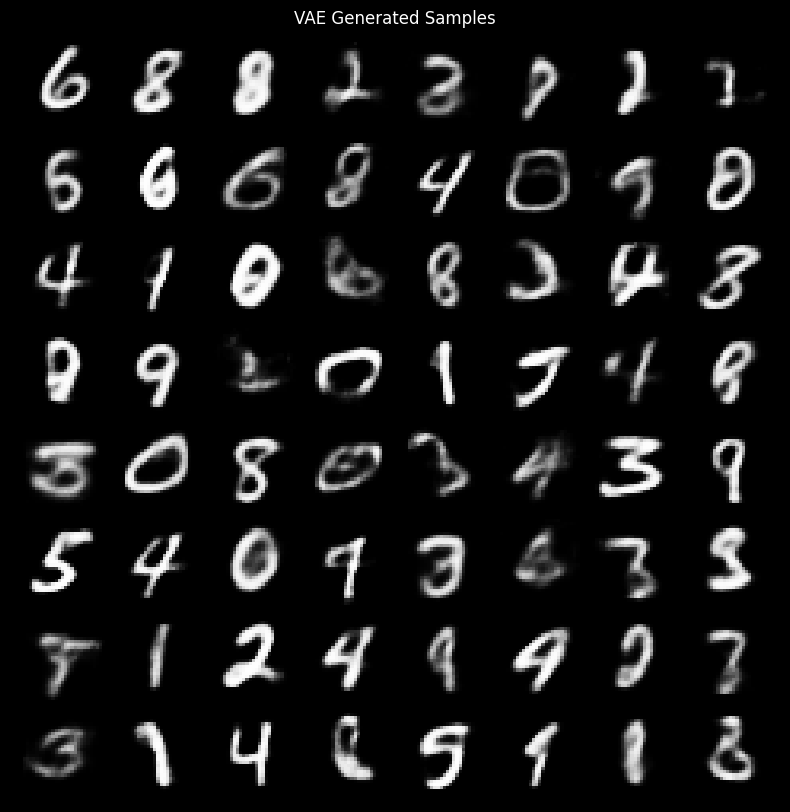

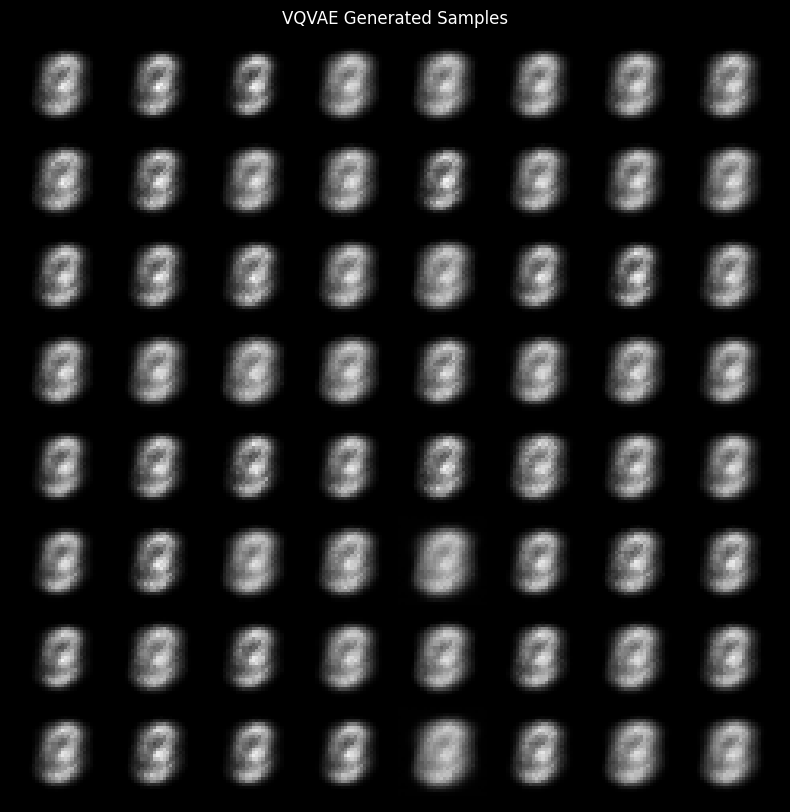

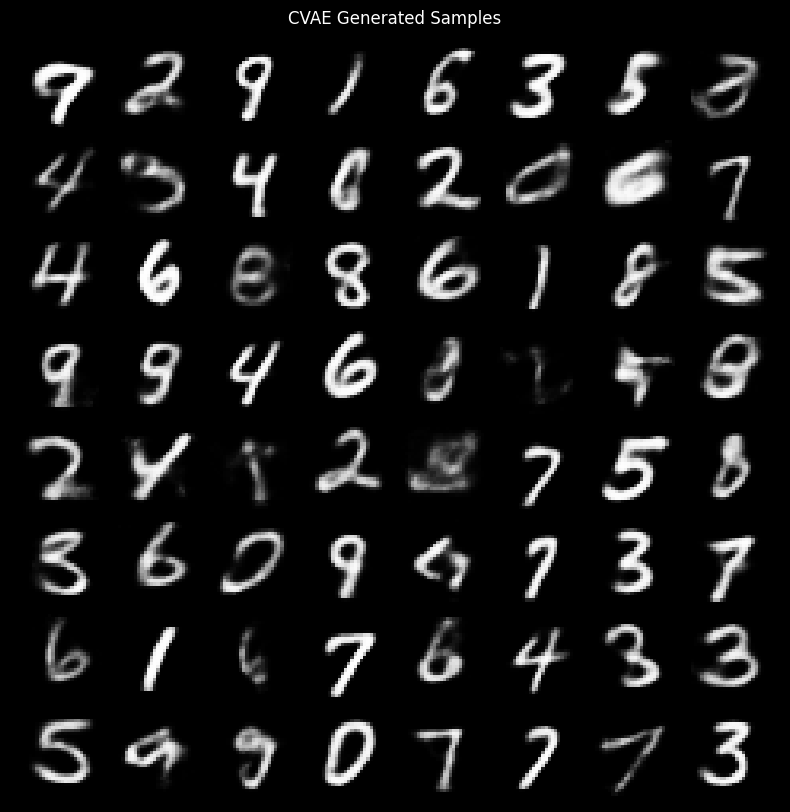

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid  # Add this import
# Standard VAE
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# VQ-VAE
class VQVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_embeddings):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.codebook = nn.Embedding(num_embeddings, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        distances = torch.cdist(z, self.codebook.weight)
        indices = torch.argmin(distances, dim=1)
        quantized = self.codebook(indices)
        return quantized, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x.view(-1, 784))
        z_q, indices = self.quantize(z)
        x_recon = self.decode(z_q)
        return x_recon, z, z_q, indices

# Conditional VAE
class CVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        self.num_classes = num_classes

    def encode(self, x, c):
        inputs = torch.cat([x, c], dim=1)
        h = self.encoder(inputs)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        inputs = torch.cat([z, c], dim=1)
        return self.decoder(inputs)

    def forward(self, x, c):
        mu, logvar = self.encode(x.view(-1, 784), c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

# Loss functions
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def vqvae_loss(recon_x, x, z, z_q):
    recon_loss = F.mse_loss(recon_x, x.view(-1, 784))
    vq_loss = F.mse_loss(z_q, z.detach())
    commitment_loss = F.mse_loss(z_q.detach(), z)
    return recon_loss + vq_loss + 0.25 * commitment_loss

def cvae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training function
def train(model, device, train_loader, optimizer, epoch, loss_function, model_type='vae'):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        
        if model_type == 'vae':
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
        elif model_type == 'vqvae':
            recon_batch, z, z_q, _ = model(data)
            loss = loss_function(recon_batch, data, z, z_q)
        elif model_type == 'cvae':
            c = F.one_hot(labels, num_classes=10).float()
            recon_batch, mu, logvar = model(data, c)
            loss = loss_function(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')


# Main function
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load MNIST dataset
    train_loader = DataLoader(
        datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor()),
        batch_size=128, shuffle=True)

    # Train VAE
    vae = VAE(784, 400, 20).to(device)
    optimizer = optim.Adam(vae.parameters())
    for epoch in range(1, 11):
        train(vae, device, train_loader, optimizer, epoch, vae_loss, 'vae')

    # Train VQ-VAE
    vqvae = VQVAE(784, 400, 20, 512).to(device)
    optimizer = optim.Adam(vqvae.parameters())
    for epoch in range(1, 11):
        train(vqvae, device, train_loader, optimizer, epoch, vqvae_loss, 'vqvae')

    # Train CVAE
    cvae = CVAE(784, 400, 20, 10).to(device)
    optimizer = optim.Adam(cvae.parameters())
    for epoch in range(1, 11):
        train(cvae, device, train_loader, optimizer, epoch, cvae_loss, 'cvae')

    # Visualization function
    def visualize_model(model, model_type):
        model.eval()
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            if model_type == 'vae':
                sample = model.decode(sample).cpu()
            elif model_type == 'vqvae':
                sample = model.decode(model.codebook(torch.randint(0, 512, (64,)).to(device))).cpu()
            elif model_type == 'cvae':
                c = F.one_hot(torch.randint(0, 10, (64,)), num_classes=10).float().to(device)
                sample = model.decode(sample, c).cpu()
            
            sample = sample.view(64, 1, 28, 28)
            grid = make_grid(sample, nrow=8, normalize=True)
            plt.figure(figsize=(10, 10))
            plt.imshow(grid.permute(1, 2, 0), cmap='gray')
            plt.title(f'{model_type.upper()} Generated Samples')
            plt.axis('off')
            plt.show()

    visualize_model(vae, 'vae')
    visualize_model(vqvae, 'vqvae')
    visualize_model(cvae, 'cvae')

if __name__ == '__main__':
    main()